## Custom ResNet20 Architecture
### Occlusion Test

In this notebook, we will explore a Custom ResNet20 Architecture. The decision to use ResNet20 comes from its unique structure, which is often overlooked in favor of more modern or larger variants like ResNet50 or ResNet101. This choice provides a deeper understanding of how residual networks operate and how their principles can be applied even in simpler, smaller architectures and taking under consideration our GPU resource contraints.


Reference: He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep Residual Learning for Image Recognition. arXiv. https://arxiv.org/abs/1512.03385



In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

Grid Occulusion Techinque will be used as explained in the README of this challenge.

In [4]:
def grid_occlusion(img, grid_size, drop_prob):
    _, h, w = img.shape
    mask = torch.ones((h, w))

    for i in range(0, h, grid_size):
        for j in range(0, w, grid_size):
            if torch.rand(1).item() < drop_prob:
                mask[i:i+grid_size, j:j+grid_size] = 0

    img = img * mask
    return img

class GridOcclusionTransform:
    def __init__(self, grid_size=4, drop_prob=0.2):
        self.grid_size = grid_size
        self.drop_prob = drop_prob

    def __call__(self, img):
        return grid_occlusion(img, self.grid_size, self.drop_prob)


def data_loader(data_dir,
                    batch_size,
                    random_seed=42,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            GridOcclusionTransform(),
            normalize,
        ])
        transform_test = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            GridOcclusionTransform(),

            normalize,
        ])
        download = not os.path.exists(os.path.join(data_dir, "cifar-10-batches-py"))
        print(download)
        if test:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=download, transform=transform_test,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=download, transform=transform,
        )


        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=2,pin_memory=True)

        valid_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)
train_loader, valid_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                             batch_size=128)

test_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                  batch_size=128,
                                  test=True)

True


100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


False


## You can check the effect of our Grid Occlusion technique here

In [ ]:
image, labels = next(iter(test_loader))
plt.imshow(image[116].permute(1,2,0))

A Residual Block is the fundamental building block of the ResNet architecture, designed to solve the vanishing gradient problem by introducing skip connections. These skip connections allow the input to bypass the convolutional layers and be added directly to the output, creating a shortcut path for gradients during backpropagation. This helps the network learn residual mappings, improving the model's performance and convergence.

In [5]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.relu=nn.ReLU()
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.downsample = downsample
            self.out_channels = out_channels
            #self.skip_add = nn.quantized.FloatFunctional()
        def forward(self, x):
            residual = x
            y = self.conv1(x)
            y = self.bn1(y)
            y = self.relu(y)
            y = self.conv2(y)
            y = self.bn2(y)
            if self.downsample:
                residual = self.downsample(x)
            y += residual
            y = self.relu(y)
            return y

The ResNet class implements the ResNet architecture using PyTorch's nn.Module. It starts with a convolutional layer followed by batch normalization and ReLU activation. The network is built using residual blocks, created by the _make_layer function, which constructs layers of blocks with skip connections. The forward method defines the flow of the input through the network, ending with an adaptive average pooling layer and a fully connected layer for classification.

In [6]:
import torch.nn.init as init

class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 10):
            super(ResNet, self).__init__()
            self.inplanes = 16
            #self.quant = torch.quantization.QuantStub()
            self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1)
            self.bn1 = nn.BatchNorm2d(16)
            self.relu=nn.ReLU()
            #self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 16, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 32, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 64, layers[2], stride = 2)
            self.avgpool = nn.AdaptiveAvgPool2d(1)
            self.fc = nn.Linear(64, num_classes)
            self._initialize_weights()  # Apply He initialization
            #self.dequant = torch.quantization.DeQuantStub()
        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        init.zeros_(m.bias)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x

In [7]:
# Hyperparameters
num_classes = 10
num_epochs = 10
batch_size = 128
learning_rate = 0.05

# Model
model = ResNet(ResidualBlock, [3, 3, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8], gamma=0.2)


In [8]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


The training loop includes model checkpointing, which saves the model, optimizer, and scheduler states every two epochs to allow resuming training if interrupted. It also implements early stopping based on validation accuracy, halting training after three consecutive epochs of no improvement. Additionally, the loop ensures efficient memory management by clearing tensors and invoking garbage collection after each batch.

In [9]:
import gc
import time

checkpoint_path = "/content/drive/MyDrive/here.pth"


start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
total_step = len(train_loader)
best_val = -1
tolerance = 3
t = 0
loss_info = {'train':[], 'val':[]}
for epoch in range(start_epoch, num_epochs):
    t = time.time()
    for i, (images, labels) in enumerate(train_loader):

        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    scheduler.step()
    if (epoch + 1) % 2 == 0:
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state":scheduler.state_dict()
        }, os.path.join(os.path.dirname(checkpoint_path), f"vgg19_occulusion_{epoch+1}.pth"))
        print(f"Checkpoint saved at epoch {epoch+1}")
    print ('epoch {}, Train loss: {:.4f}'.format(epoch+1, loss.item()))
    print("Time: {:.2f}".format( time.time()-t))
    loss_info['train'].append(loss.item())

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        loss_total = 0
        batch_size = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_size+=1

        loss_avg = loss_total/batch_size
        val_acc = 100 * correct / total
        print(f'Val acc: {val_acc:.4f}%    Val loss: {loss_avg: .2f}')
        loss_info['val'].append(loss_avg)


    if epoch > 0 and val_acc <= best_val:
        tolerance -= 1
        if tolerance == 0:
            print("early stopping")
            break
    else:
        best_val = val_acc
        tolerance = 3

epoch 1, Train loss: 1.6126
Time: 100.62
Val acc: 38.2200%    Val loss:  1.64
Checkpoint saved at epoch 2
epoch 2, Train loss: 1.3167
Time: 96.65
Val acc: 49.0000%    Val loss:  1.39
epoch 3, Train loss: 1.0244
Time: 92.84
Val acc: 57.2000%    Val loss:  1.19
Checkpoint saved at epoch 4
epoch 4, Train loss: 1.0040
Time: 95.69
Val acc: 63.3200%    Val loss:  1.02
epoch 5, Train loss: 0.7643
Time: 94.48
Val acc: 67.4800%    Val loss:  0.93
Checkpoint saved at epoch 6
epoch 6, Train loss: 0.8609
Time: 93.49
Val acc: 69.3800%    Val loss:  0.86
epoch 7, Train loss: 0.6977
Time: 94.72
Val acc: 73.0400%    Val loss:  0.77
Checkpoint saved at epoch 8
epoch 8, Train loss: 0.8052
Time: 96.92
Val acc: 74.4800%    Val loss:  0.76
epoch 9, Train loss: 0.5802
Time: 94.13
Val acc: 77.6200%    Val loss:  0.64
Checkpoint saved at epoch 10
epoch 10, Train loss: 0.5422
Time: 93.73
Val acc: 79.1400%    Val loss:  0.60


### Loss Curve

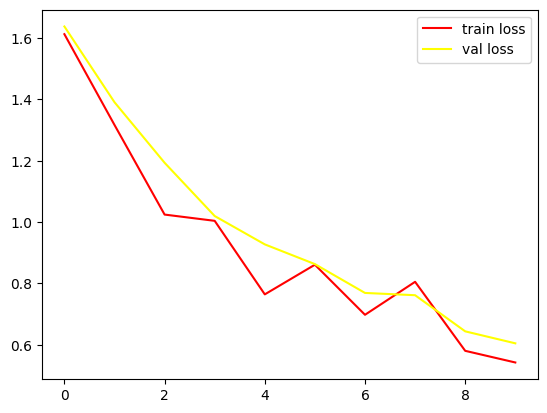

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_info['train'])), loss_info['train'], color='red', label='train loss')
plt.plot(range(len(loss_info['val'])), loss_info['val'], color='yellow', label='val loss')

plt.legend()

plt.show()

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_labels):
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.show()

### Check Original Model
We first test older model weights to analyze robustness on altered images. This model was trained on clean non-altered images.

test Accuracy : 41.43 %


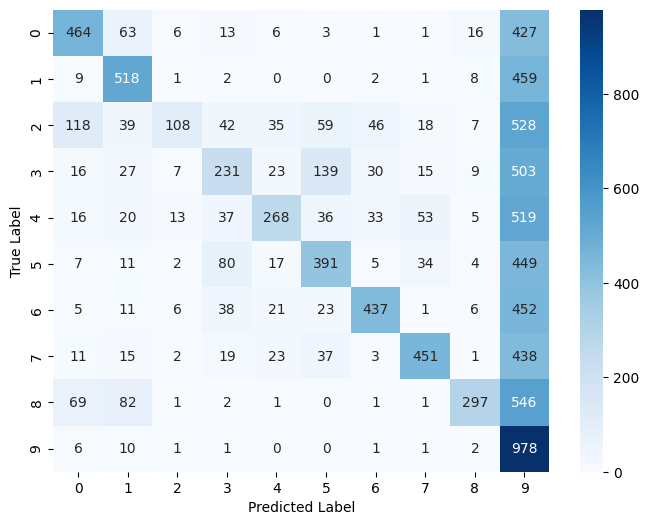

In [14]:
checkpoint = torch.load('/content/resnet20_fast.pth', map_location=device)
model.load_state_dict(checkpoint)
y_pred = []
y_true = []
model.to(device)
model.eval()
with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        acc =correct / total

print('test Accuracy : {:.2f} %'.format(acc*100))
plot_confusion_matrix(y_true, y_pred, range(0,10))

### Check our new model

The test set is also randomly altered with probability of 0.2

test Accuracy : 78.49 %


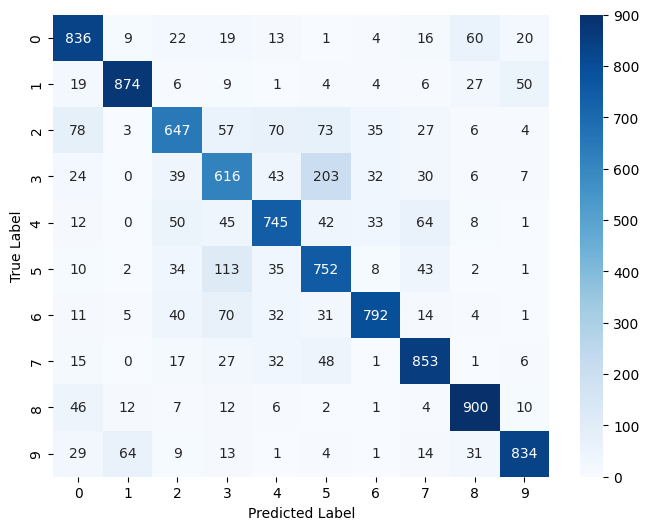

In [12]:
checkpoint = torch.load('/content/drive/MyDrive/vgg19_occulusion_10.pth', map_location=device)
model.load_state_dict(checkpoint['model_state'])
y_pred = []
y_true = []
model.to(device)
model.eval()
with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        acc =correct / total

print('test Accuracy : {:.2f} %'.format(acc*100))
plot_confusion_matrix(y_true, y_pred, range(0,10))

# Scores

#### First, we check the original model's behaviour
*This model was trained in the past with clean/unaltered cifar10 images.*
$$
\text{Pure Model Robustness} = \frac{\text{Accuracy on occluded images}}{\text{Accuracy on non-occluded images}}= 41.43 / 81.23 = 0.51
$$




#### Now, we check the newly trained model's improvement compared to original
*This will be indicative of the need to train on altered images.*
$$
\text{Trained Model Robustness Improvement} = \frac{\text{New model accuracy on occluded images}}{\text{Old model accuracy on occluded images}}= 78.49 / 41.43 = 1.89
$$
   